#### Author: Arun Ramesh, University of Houston. https://rpglab.github.io/people/Arun-Venkatesh-Ramesh/
#### Source webpage: https://rpglab.github.io/resources/FL-ML-R-SCUC_Python/
#### If you use any codes/data here for your work, please cite the following paper: 
#####       Arun Venkatesh Ramesh and Xingpeng Li, “Feasibility Layer Aided Machine Learning Approach for Day-Ahead Operations”, IEEE Transactions on Power Systems, Apr. 2023.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
np.random.seed(1)

import sys
nums = np.arange(2000)
np.set_printoptions(threshold=sys.maxsize)

import csv
import time
from timeit import default_timer as timer

In [38]:
##### data set 24 Bus 8 Prd

dfX_24_s1 = pd.read_csv("demand24Bus24Prd_Renewable_Scn1.txt")
dfX_24_s2 = pd.read_csv("demand24Bus24Prd_Renewable_Scn2.txt")
dfX_24_s3 = pd.read_csv("demand24Bus24Prd_Renewable_Scn3.txt")

dfY_24 = pd.read_csv("commitment24Bus24Prd_Renewable.txt")

print(dfX_24_s1.info)
print(dfX_24_s2.info)
print(dfX_24_s3.info)

print(dfY_24.info)

x1 = dfX_24_s1.to_numpy()
x2 = dfX_24_s2.to_numpy()
x3 = dfX_24_s3.to_numpy()
#x = np.delete(x,0,1) #delete column one sample number
x1 = x1/100
x2 = x2/100
x3 = x3/100
#print(x[1])

y = dfY_24.to_numpy()
#y = np.delete(y,0,1) #delete column one sample number
#print(y[1])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x1 = x1[indices]
x2 = x2[indices]
x3 = x3[indices]
y = y[indices]

# Explicitly set apart 20% for validation data that we never train over.
split_at = len(y) - len(y) // 5
(x_train_s1, x_test_s1) = x1[:split_at], x1[split_at:]
(x_train_s2, x_test_s2) = x2[:split_at], x2[split_at:]
(x_train_s3, x_test_s3) = x3[:split_at], x3[split_at:]

(y_train, y_test) = y[:split_at], y[split_at:]


print(len(x_train_s1))
print(len(y_train))

print(len(x_test_s1))
print(len(y_test))

#print(indices)

#print(x_train[1])
#print(y_train[1])

#print(x_test[1])
#print(y_test[1])

<bound method DataFrame.info of       83.24954458770935  54.34425794312568  70.00361620999341  \
0             70.800304          57.900420          58.226554   
1             94.075504          51.341739          72.431930   
2             85.665204          57.013669          74.088633   
3             99.176060          61.681205          75.873126   
4             76.482038          58.963837          68.883490   
...                 ...                ...                ...   
1694          90.166408           9.069035          74.746805   
1695          85.276524          19.466855          68.654320   
1696          80.525103          16.817815          64.564100   
1697          77.630299          29.509748          62.965599   
1698          89.777069           3.606266          81.166157   

      119.43565292053046  54.179019689274426  121.82788019680731  0  \
0             100.296206           45.766282           98.643001  0   
1             124.963262           58.218337 

In [39]:
print(x_train_s1.shape)
print(x_train_s2.shape)
print(x_train_s3.shape)
x_train = np.concatenate((x_train_s1, x_train_s2, x_train_s3), axis=1)
print(x_train.shape)
print(y_train.shape)

print(x_test_s1.shape)
print(x_test_s2.shape)
print(x_test_s3.shape)
x_test = np.concatenate((x_test_s1, x_test_s2, x_test_s3), axis =1)
print(x_test.shape)
print(y_test.shape)

(1360, 576)
(1360, 576)
(1360, 576)
(1360, 1728)
(1360, 792)
(339, 576)
(339, 576)
(339, 576)
(339, 1728)
(339, 792)


In [40]:
# x_train_s1 = x_train_s1.T
# x_train_s2 = x_train_s2.T
# x_train_s3 = x_train_s3.T
x_train = x_train.T
y_train = y_train.T

# x_test_s1 = x_test_s1.T
# x_test_s2 = x_test_s2.T
# x_test_s3 = x_test_s3.T
x_test = x_test.T
y_test = y_test.T

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.preprocessing import StandardScaler # data normalization
#X_var = StandardScaler().fit(X_var).transform(x_train.T)

TrainScore = []
TestScore = []
NgxNt = y_train.shape[0]
m_Tr = x_train.shape[1]
m_Ts = x_test.shape[1]

Y_hat_tr_skln_pred = np.zeros((m_Tr,NgxNt))
Y_hat_ts_skln_pred = np.zeros((m_Ts,NgxNt))

A_tr_skln_pred = np.zeros((m_Tr,NgxNt))
A_ts_skln_pred = np.zeros((m_Ts,NgxNt))

start = timer()
for i in range(NgxNt):
    #print ("Ng*Nt: ",i)   
    
    if set([0,1]).issubset(set(y_train[i])):      
        
        #logreg = MultiOutputRegressor(LogisticRegression(multi_class='multinomial', solver='lbfgs'))
        logreg = LogisticRegression(random_state=0, solver='liblinear', max_iter = 100)
        logreg.fit(x_train.T,y_train[i]) #original shape before transposed
        Y_hat_tr_skln_pred[:,i] = logreg.predict(x_train.T)
        A_temp = logreg.predict_proba(x_train.T)
        A_tr_skln_pred[:,i] = A_temp[:,1]
        TrainScore.append(logreg.score(x_train.T,y_train[i]))
        Y_hat_ts_skln_pred[:,i] = logreg.predict(x_test.T)
        A_temp = logreg.predict_proba(x_test.T)
        A_ts_skln_pred[:,i] = A_temp[:,1]
        TestScore.append(logreg.score(x_test.T,y_test[i]))
    
    else:
        
        if set([0]).issubset(set(y_train[i])):
            Y_hat_tr_skln_pred[:,i] = np.zeros(m_Tr)
        else:
            Y_hat_tr_skln_pred[:,i] = np.ones(m_Tr)
        
        if set([0]).issubset(set(y_test[i])):
            Y_hat_ts_skln_pred[:,i] = np.zeros(m_Ts)
        else:
            Y_hat_ts_skln_pred[:,i] = np.ones(m_Ts)
            
        TrainScore.append(1)
        TestScore.append(1)
end = timer()
print("training time: ",end - start)
print ("-------------------------------------------------------")

print("training Score: ", np.mean(TrainScore))
print("testing Score: ", np.mean(TestScore))

print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_hat_tr_skln_pred)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_hat_ts_skln_pred)) * 100))

training time:  63.20332580000013
-------------------------------------------------------
training Score:  0.965548871063577
testing Score:  0.9452750216024551
train accuracy: 96.5548871063577 %
test accuracy: 94.52750216024552 %


In [15]:
x_test_round = np.around(x_test, decimals=4)
x_test_round = x_test_round.T
with open("demand24Bus24PrdTestSampleSKLRN4Ampl_renewableAllScn.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_test_round)

In [16]:
with open("commitment24Bus24PrdTestSampleSKLRN4Ampl_renewableAllScn.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_hat_ts_skln_pred)

In [48]:
A_prediction_test_round = np.around(A_ts_skln_pred, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities24Bus24PrdTestSampleSKLRN4Ampl_Renewable.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_test_round)

In [17]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros(shape=(dim,792))
    b = 0
    return w, b

In [18]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / ( 1 + np.exp(-z))
    return s

In [19]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    
    m = X.shape[0]
    
    #print(m)
    
    #print(w.shape)
    #print(X.shape)
    #print(b)
    b = np.sum(b) #try b.T
    #print(b)
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)             # compute activation
    #print(A.shape)
    #print(Y.shape)
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost
    #print(cost.shape)
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == (792,))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        #if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        #if print_cost and i % 100 == 0:
        #    print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [21]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = X.shape[1]
    #Y_prediction = np.zeros((792, m))
    w = w.reshape(X.shape[0], 792)
    b = np.sum(b)
    
    # Compute vector "A" predicting the probabilities commitment
    A = sigmoid(np.dot(w.T, X) + b)
    #print (A.shape)
    #print(A.T)        
    return A

In [22]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [26]:
print (x_train.shape)
print (y_train.shape)

learning_rates = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05]
#learning_rates = [0.01]
models = {}
for i in learning_rates:
    start = timer()
    print ("learning rate is: ",i)
    models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 100, learning_rate = i, print_cost = True)
    end = timer()
    print("training time: ",end - start)
    print ("-------------------------------------------------------")

(1728, 1360)
(792, 1360)
learning rate is:  0.001
train accuracy: 90.41681454268479 %
test accuracy: 90.44052274073921 %
training time:  9.134658700000045
-------------------------------------------------------
learning rate is:  0.003
train accuracy: 91.11236715291716 %
test accuracy: 91.11757664759551 %
training time:  9.041547099999889
-------------------------------------------------------
learning rate is:  0.005
train accuracy: 91.33429827662505 %
test accuracy: 91.32744696832577 %
training time:  9.079647100000102
-------------------------------------------------------
learning rate is:  0.008
train accuracy: 91.53876801156508 %
test accuracy: 91.51837188160206 %
training time:  9.040876900000058
-------------------------------------------------------
learning rate is:  0.01
train accuracy: 91.49354969389391 %
test accuracy: 91.53758372722548 %
training time:  9.05555100000015
-------------------------------------------------------
learning rate is:  0.03
train accuracy: 92.1654

<ipython-input-19-9f7c41a8f593>:31: RuntimeWarning: divide by zero encountered in log
  cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost
<ipython-input-19-9f7c41a8f593>:31: RuntimeWarning: invalid value encountered in multiply
  cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost


train accuracy: 91.89708440148195 %
test accuracy: 91.91709473947525 %
training time:  9.097070699999904
-------------------------------------------------------


In [31]:
for i in learning_rates:
    print ("learning rate is: ",i)
    w = models[i]["w"]
    b = models[i]["b"]
    A_prediction_test = predict(w, b, x_test)
    A_prediction_test = A_prediction_test.T
    
    m = A_prediction_test.shape[0]
    Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
    P = 0.5

    for j in range(m):
        for i in range(A_prediction_test.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_test[j, i] >= P:
                Y_test_hackFull[j, i] = 1
            
            else:
                Y_test_hackFull[j, i] = 0
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
    A_prediction_train = predict(w, b, x_train)
    A_prediction_train = A_prediction_train.T
    
    m = A_prediction_train.shape[0]
    Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
    for j in range(m):
        for i in range(A_prediction_train.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_train[j, i] >= P:
                Y_train_hackFull[j, i] = 1
            
            else:
                Y_train_hackFull[j, i] = 0
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
    print ("-------------------------------------------------------")
   

learning rate is:  0.001
test accuracy: 93.24401835463783 %
train accuracy: 93.17058452168746 %
-------------------------------------------------------
learning rate is:  0.003
test accuracy: 93.6760674592533 %
train accuracy: 93.63849896019013 %
-------------------------------------------------------
learning rate is:  0.005
test accuracy: 93.8663925389589 %
train accuracy: 93.85453802733214 %
-------------------------------------------------------
learning rate is:  0.008
test accuracy: 94.01053305920563 %
train accuracy: 94.03529783125371 %
-------------------------------------------------------
learning rate is:  0.01
test accuracy: 92.30878102559518 %
train accuracy: 92.26390745692217 %
-------------------------------------------------------
learning rate is:  0.03
test accuracy: 92.26892822025566 %
train accuracy: 92.25592320261438 %
-------------------------------------------------------
learning rate is:  0.05
test accuracy: 92.001132266619 %
train accuracy: 91.98074494949495 %

In [32]:
i = 0.008
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_test = predict(w, b, x_test)
A_prediction_test = A_prediction_test.T
    
m = A_prediction_test.shape[0]
Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
P = 0.5

for j in range(m):
    for k in range(A_prediction_test.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_test[j, k] >= P:
            Y_test_hackFull[j, k] = 1
            
        else:
            Y_test_hackFull[j, k] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
A_prediction_train = predict(w, b, x_train)
A_prediction_train = A_prediction_train.T
    
m = A_prediction_train.shape[0]
Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
for j in range(m):
    for k in range(A_prediction_train.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_train[j, k] >= P:
            Y_train_hackFull[j, k] = 1
            
        else:
            Y_train_hackFull[j, k] = 0
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
print ("-------------------------------------------------------")

learning rate is:  0.008
test accuracy: 94.01053305920563 %
train accuracy: 94.03529783125371 %
-------------------------------------------------------


In [33]:
with open("commitment24Bus24PrdTestSample4Ampl_Renewable.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_test_hackFull)

In [34]:
x_test_round = np.around(x_test, decimals=4)
x_test_round = x_test_round.T
with open("demand24Bus24PrdTestSample4Ampl_Renewable.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_test_round)

In [35]:
A_prediction_test_round = np.around(A_prediction_test, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities24Bus24PrdTestSample4Ampl_Renewable.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_test_round)

In [38]:
with open("UgtAct24Bus24PrdTest4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(y_test.T)

In [39]:
x_train_round = np.around(x_train, decimals=3)
x_train_round = x_train_round.T
with open("demand24PrdTrainSample4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(x_train_round)

In [40]:
A_prediction_train_round = np.around(A_prediction_train, decimals=6)
with open("probabilities24Bus24PrdTrainSample4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(A_prediction_train_round)

In [41]:
with open("UgtAct24Bus24PrdTrain4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(y_train.T)

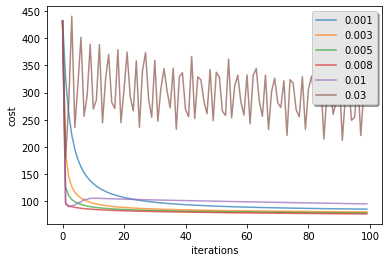

[[432.06174255 325.17981831 261.85329349 222.06396668 195.48281785
  176.76599861 163.00647304 152.53035018 144.32179753 137.73534646
  132.34430442 127.85683685 124.06738991 120.82743498 118.02722267
  115.58404605 113.43448105 111.52912939 109.82897811 108.30282829
  106.92544636 105.67621314 104.53812197 103.49702549 102.54106251
  101.66021662 100.84597293 100.09104827  99.38917736  98.73494186
   98.12363259  97.55113773  97.01385141  96.50859857  96.03257276
   95.58328435  95.15851726  94.75629254  94.37483757  94.01256
   93.66802544  93.33993846  93.02712619  92.72852423  92.44316444
   92.1701643   91.90871773  91.658087    91.41759564  91.18662226
   90.96459505  90.75098697  90.54531144  90.34711858  90.15599179
   89.97154474  89.7934187   89.62128012  89.45481846  89.29374423
   89.13778727  88.98669515  88.84023176  88.69817599  88.56032057
   88.42647103  88.2964447   88.17006985  88.04718486  87.92763753
   87.81128436  87.69798998  87.58762655  87.48007326  87.3752158

In [37]:
plt.clf()

NCost = int(models[0.008]["num_iterations"])#/100)

costarray_full = np.zeros((len(learning_rates),NCost))
costarray_single = np.zeros(NCost)

#print (NCost)
for i in range(6):#len(learning_rates)):
    costarray_single = np.zeros(NCost)
    for j in range(NCost):
        #print (j)
        costarray_single[j] = np.sum(np.squeeze(models[learning_rates[i]]["costs"][j])) 
    costarray_full[i] = costarray_single
    plt.plot(costarray_full[i], label= str(models[learning_rates[i]]["learning_rate"]),alpha=0.7)
    #print (np.squeeze(models[i]["costs"][2]))

#plt.plot(costarray_full[i], label= str(models[0.001]["learning_rate"]), alpha=1)
#plt.plot(np.squeeze(models[0.001]["costs"][1]), label= str(models[0.001]["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

print (costarray_full)



In [40]:
plt.clf()
#grid=[x for x in range(7)]
i = 0
for gg,graph in enumerate(costarray_full[0:6]):
    lw=10-8*gg/len(costarray_full)
    ls=['-','--','-.',':'][gg%4]
    #plt.plot(grid,graph,label=str(models[learning_rates[i]]["learning_rate"]), linestyle=ls, linewidth=lw)
    plt.plot(graph,label=str(models[learning_rates[i]]["learning_rate"]), linestyle=ls, linewidth=lw)
    i = i+1
    
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='center right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()